# Marketing Mix Model

# 1. Importing Libraries & Dataset

In [567]:
import warnings
import itertools
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter
import re
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
import pylab as pl
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline

In [568]:
marketing_data = pd.read_csv('../Jupyter/sales_orders_traffic.csv')

In [569]:
marketing_data.columns.values

array(['     Dates         Calendar Date', 'Total Gross Sales',
       'Total Gross Orders', 'Guideshop Sales', 'Guideshop Orders',
       'Web Gross Sales', 'Web Orders', 'Guideshop Traffic', 'Web Traffic',
       'spend_affiliate', 'spend_catalog', 'spend_display_prospecting',
       'spend_display_retargeting', 'spend_paid_search',
       'spend_paid_social', 'impressions_affiliate', 'impressions_catalog',
       'impressions_display_prospecting',
       'impressions_display_retargeting', 'impressions_email',
       'impressions_guideshop', 'impressions_paid_search',
       'impressions_paid_social', 'click_affiliate',
       'click_display_prospecting', 'click_display_retargeting',
       'click_email', 'click_paid_search', 'click_paid_social',
       'spend_linkedin', 'impressions_linkedin', 'click_linkedin',
       'impressions_quartz', 'click_quartz', 'impressions_pandora',
       'click_pandora', 'spend_thehustle', 'impressions_thehustle',
       'click_thehustle', 'spend_ooh',

In [570]:
marketing_data.isnull().sum()

     Dates         Calendar Date    0
Total Gross Sales                   0
Total Gross Orders                  0
Guideshop Sales                     0
Guideshop Orders                    0
Web Gross Sales                     0
Web Orders                          0
Guideshop Traffic                   0
Web Traffic                         0
spend_affiliate                     0
spend_catalog                       0
spend_display_prospecting           0
spend_display_retargeting           0
spend_paid_search                   0
spend_paid_social                   0
impressions_affiliate               0
impressions_catalog                 0
impressions_display_prospecting     0
impressions_display_retargeting     0
impressions_email                   0
impressions_guideshop               0
impressions_paid_search             0
impressions_paid_social             0
click_affiliate                     0
click_display_prospecting           0
click_display_retargeting           0
click_email 

In [577]:
marketing_data['total_spend'] = marketing_data['spend_affiliate'] + marketing_data['spend_catalog'] + marketing_data['spend_display_prospecting'] + marketing_data['spend_display_retargeting'] + marketing_data['spend_paid_search'] + marketing_data['spend_paid_social']
marketing_data['total_impressions'] = marketing_data['impressions_affiliate'] + marketing_data['impressions_catalog'] + marketing_data['impressions_display_prospecting'] + marketing_data['impressions_display_retargeting'] + marketing_data['impressions_email'] + marketing_data['impressions_guideshop'] + marketing_data['impressions_paid_search'] + marketing_data['impressions_paid_social']
marketing_data['total_click'] = marketing_data['click_affiliate'] + marketing_data['click_display_prospecting'] + marketing_data['click_display_retargeting'] + marketing_data['click_email'] + marketing_data['click_paid_search'] + marketing_data['click_paid_social']
marketing_data = marketing_data.rename(index=str, columns={'     Dates         Calendar Date': 'dates'})

# 2. Exploring the dataset

In [578]:
marketing_data['total_spend'].describe()

count    7.520000e+02
mean     3.687288e+04
std      1.135130e+05
min      4.837880e+02
25%      8.203293e+03
50%      1.535294e+04
75%      2.428109e+04
max      1.779275e+06
Name: total_spend, dtype: float64

In [579]:
marketing_data['Total Gross Sales'].describe()

count    7.520000e+02
mean     4.066366e+05
std      2.735854e+05
min      9.644504e+04
25%      2.853796e+05
50%      3.594692e+05
75%      4.664713e+05
max      4.754363e+06
Name: Total Gross Sales, dtype: float64

Skewness: 9.031492
Kurtosis: 122.683818


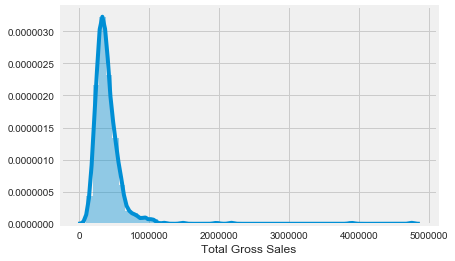

In [580]:
#Gross Sales deviates from normal distribution, has appreciable positive right skewness, and shows peakedness (leptokurtic)
sns.distplot(marketing_data['Total Gross Sales'])

#skewness and kurtosis: a perfectly symmetrical dataset with normal distribution has a skewness and kurtosis of 0. 
print("Skewness: %f" % marketing_data['Total Gross Sales'].skew())
print("Kurtosis: %f" % marketing_data['Total Gross Sales'].kurt())

Skewness: 8.131288
Kurtosis: 92.192833


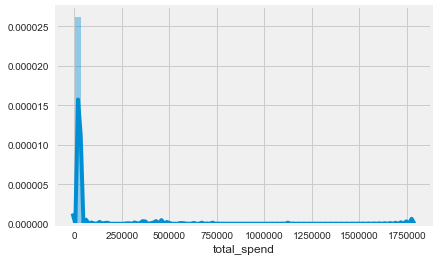

In [581]:
#Total spend deviates from normal distribution, has appreciable positive right skewness, and shows peakedness (leptokurtic)
sns.distplot(marketing_data['total_spend'])

#skewness and kurtosis: a perfectly symmetrical dataset with normal distribution has a skewness and kurtosis of 0. 
print("Skewness: %f" % marketing_data['total_spend'].skew())
print("Kurtosis: %f" % marketing_data['total_spend'].kurt())

Skewness: 27.232098
Kurtosis: 745.024622


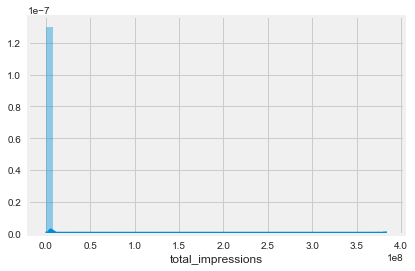

In [582]:
#Total impressions is closest to normal distribution, has a slight positive right skewness, and shows slight peakedness (leptokurtic)
sns.distplot(marketing_data['total_impressions'])

#skewness and kurtosis: a perfectly symmetrical dataset with normal distribution has a skewness and kurtosis of 0. 
print("Skewness: %f" % marketing_data['total_impressions'].skew())
print("Kurtosis: %f" % marketing_data['total_impressions'].kurt())

Skewness: 25.404484
Kurtosis: 678.038102


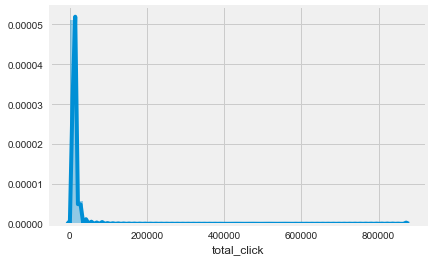

In [583]:
#Total clicks is closer to a normal distribution than gross sales and total spend, has appreciable positive right skewness, and shows peakedness (leptokurtic)
sns.distplot(marketing_data['total_click'])

#skewness and kurtosis: a perfectly symmetrical dataset with normal distribution has a skewness and kurtosis of 0. 
print("Skewness: %f" % marketing_data['total_click'].skew())
print("Kurtosis: %f" % marketing_data['total_click'].kurt())

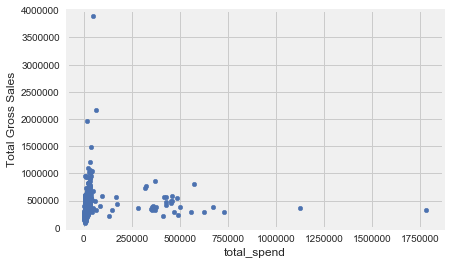

In [584]:
data = pd.concat([marketing_data['Total Gross Sales'], marketing_data['total_spend']], axis=1)
data.plot.scatter(x='total_spend', y='Total Gross Sales', ylim=(0,4000000));

y=0.160484x+(400719.129356)


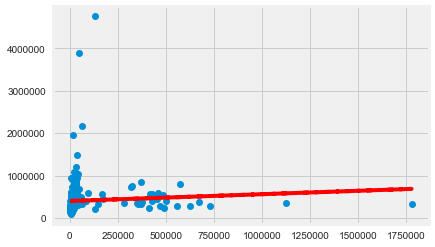

In [585]:
x = marketing_data['total_spend']
y = marketing_data['Total Gross Sales']

# plot the data itself
pl.plot(x,y,'o')

# calc the trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
pl.plot(x,p(x),"r--")
# the line equation:
print "y=%.6fx+(%.6f)"%(z[0],z[1])

y=70.805802x+(566269.095806)


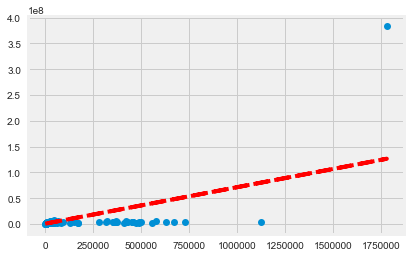

In [586]:
x = marketing_data['total_spend']
y = marketing_data['total_impressions']

# plot the data itself
pl.plot(x,y,'o')

# calc the trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
pl.plot(x,p(x),"r--")
# the line equation:

print "y=%.6fx+(%.6f)"%(z[0],z[1])

The relationship between impression and click is linear. 

y=0.002277x+(4160.492293)


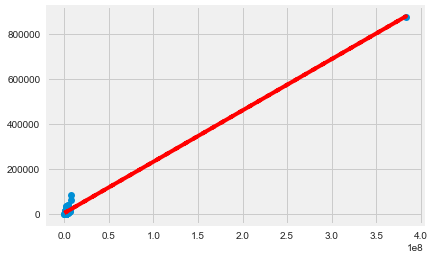

In [587]:
x = marketing_data['total_impressions']
y = marketing_data['total_click']

# plot the data itself
pl.plot(x,y,'o')

# calc the trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
pl.plot(x,p(x),"r--")
# the line equation:
print "y=%.6fx+(%.6f)"%(z[0],z[1])

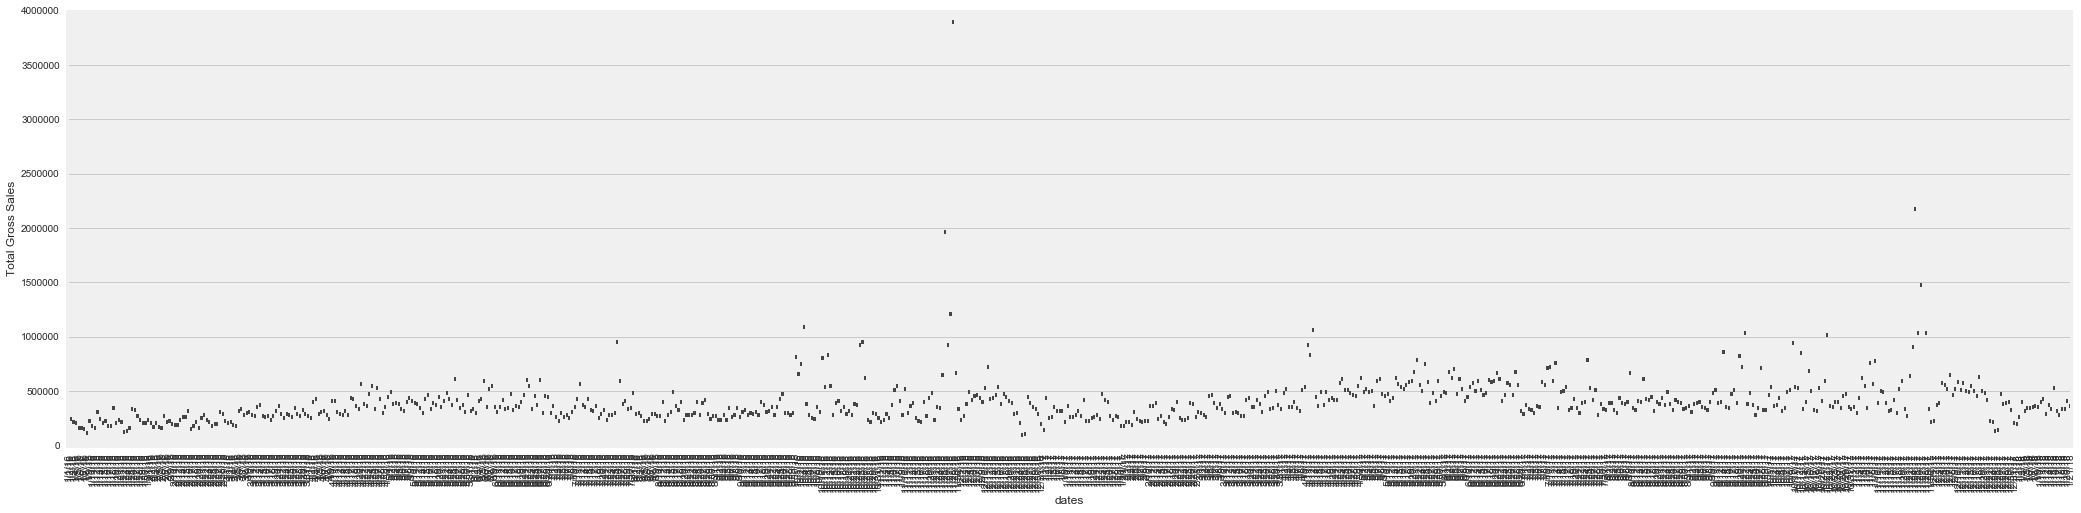

In [588]:
data = pd.concat([marketing_data['Total Gross Sales'], marketing_data['dates']], axis=1)
f, ax = plt.subplots(figsize=(32, 8))
fig = sns.boxplot(x='dates', y='Total Gross Sales', data=data)
fig.axis(ymin=0, ymax=4000000);
plt.xticks(rotation=90);

#### 'Total Gross Sales' related to 'Total Gross Orders', 'Total Click','click_email', and 'click_paid_search'. 

Guideshop Traffic ('impressions_guideshop') related to 'Guideshop Sales' and 'Guideshop Orders'
Catalog Impressions ('impressions_catalog') related to 'spend_catalog' and 'total_spend'


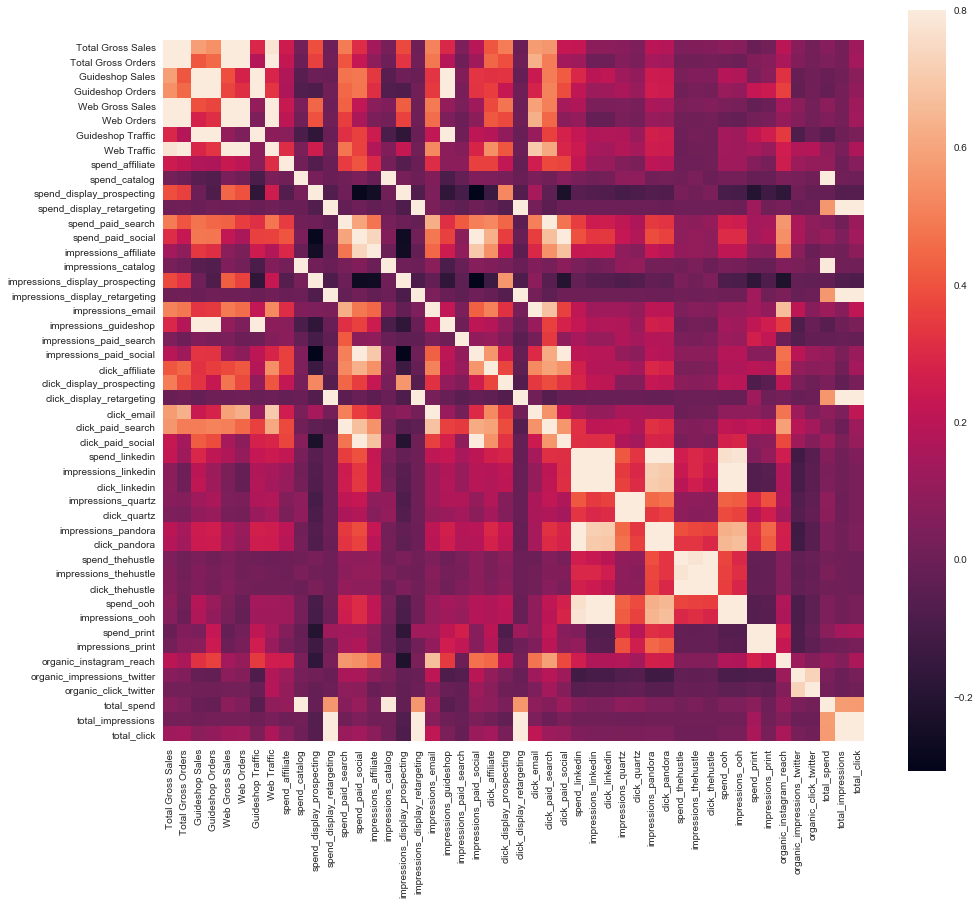

In [589]:
#correlation matrix
corrmat = marketing_data.corr()
f, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(corrmat, vmax=.8, square=True);

Gross Sales is most correlated with total_click, click_paid_search, and impressions_emails which means that those variables probably have the most impact. 

We'll 

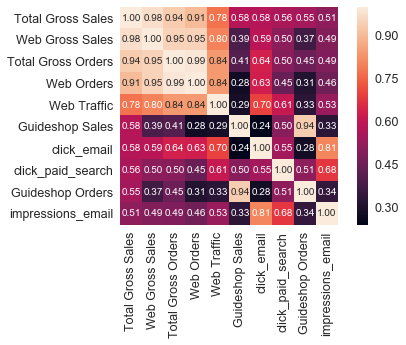

In [590]:
 #saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Total Gross Sales')['Total Gross Sales'].index
cm = np.corrcoef(marketing_data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

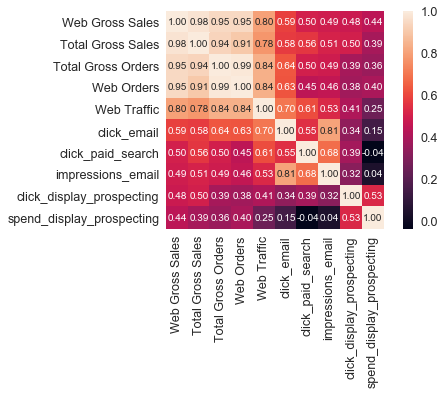

In [591]:
 #saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Web Gross Sales')['Web Gross Sales'].index
cm = np.corrcoef(marketing_data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

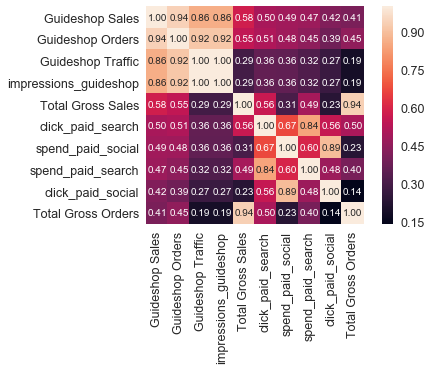

In [592]:
 #saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Guideshop Sales')['Guideshop Sales'].index
cm = np.corrcoef(marketing_data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

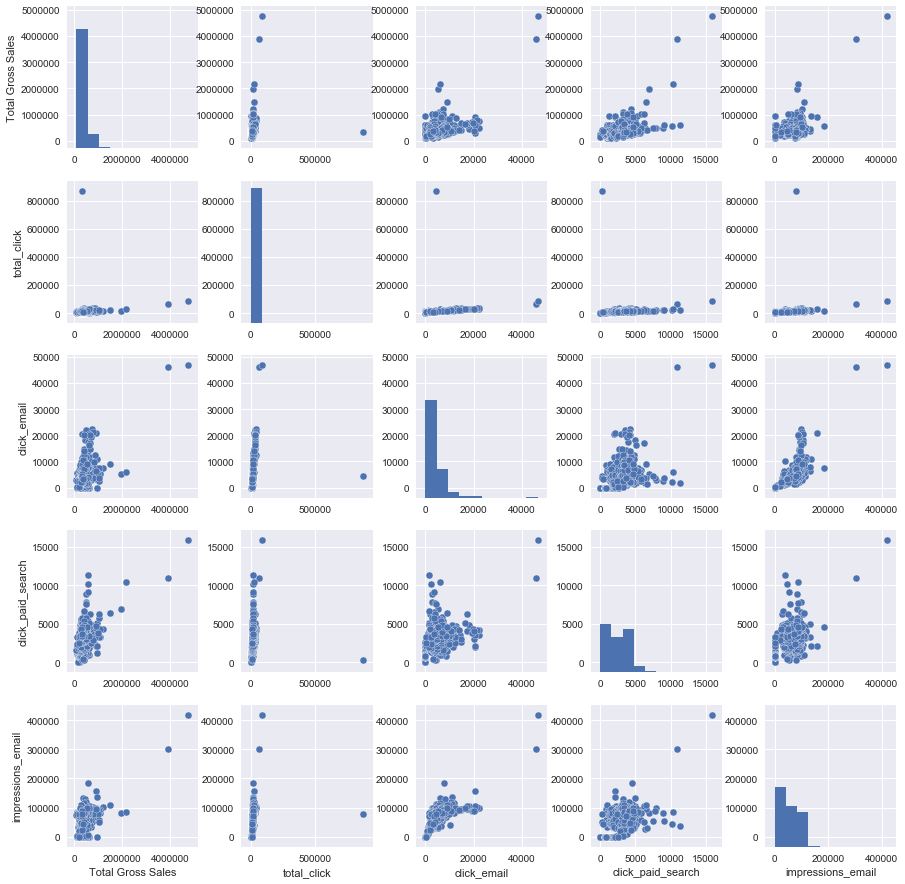

In [593]:
#scatterplot
sns.set()
cols = ['Total Gross Sales','total_click','click_email','click_paid_search','impressions_email']
sns.pairplot(marketing_data[cols], size = 2.5)
plt.show();

In [594]:
#There are no null values in our dataset
total = marketing_data.isnull().sum().sort_values(ascending=False)
percent = (marketing_data.isnull().sum()/marketing_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
total_click,0,0.0
click_affiliate,0,0.0
impressions_paid_search,0,0.0
impressions_guideshop,0,0.0
impressions_email,0,0.0
impressions_display_retargeting,0,0.0
impressions_display_prospecting,0,0.0
impressions_catalog,0,0.0
impressions_affiliate,0,0.0
spend_paid_social,0,0.0


In [595]:
#standardizing data
gross_sales_scaled = StandardScaler().fit_transform(marketing_data['Total Gross Sales'][:,np.newaxis]);
low_range = gross_sales_scaled[gross_sales_scaled[:,0].argsort()][:10]
high_range= gross_sales_scaled[gross_sales_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.13455634]
 [-1.08631678]
 [-1.07090695]
 [-1.03105032]
 [-1.00145369]
 [-0.99864487]
 [-0.95568857]
 [-0.95200098]
 [-0.92257139]
 [-0.91393865]]

outer range (high) of the distribution:
[[  2.29553816]
 [  2.29774139]
 [  2.3972953 ]
 [  2.50143379]
 [  2.94762096]
 [  3.91739812]
 [  5.68360828]
 [  6.46481751]
 [ 12.75059922]
 [ 15.90223931]]


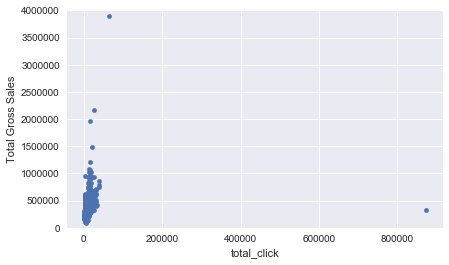

In [596]:
#bivariate analysis total gross sales/total_click
var = 'total_click'
data = pd.concat([marketing_data['Total Gross Sales'], marketing_data[var]], axis=1)
data.plot.scatter(x=var, y='Total Gross Sales', ylim=(0,4000000));

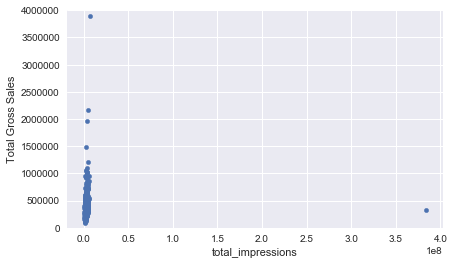

In [597]:
#bivariate analysis total gross sales/total_impressions
var = 'total_impressions'
data = pd.concat([marketing_data['Total Gross Sales'], marketing_data[var]], axis=1)
data.plot.scatter(x=var, y='Total Gross Sales', ylim=(0,4000000));

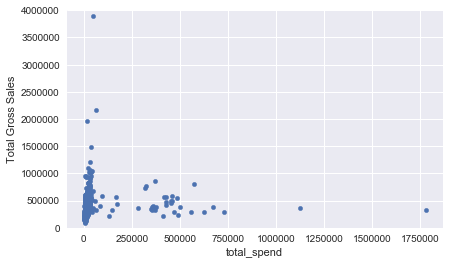

In [598]:
#bivariate analysis total gross sales/total_spend
var = 'total_spend'
data = pd.concat([marketing_data['Total Gross Sales'], marketing_data[var]], axis=1)
data.plot.scatter(x=var, y='Total Gross Sales', ylim=(0,4000000));

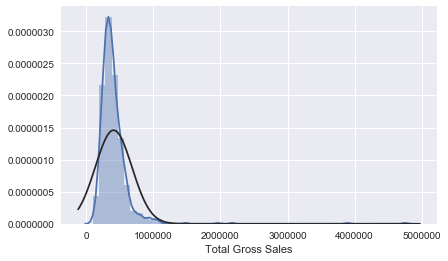

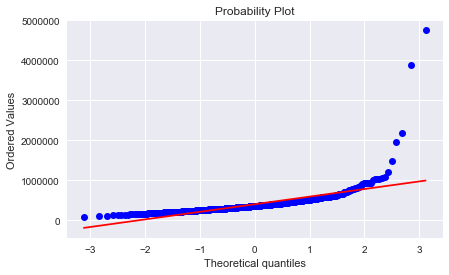

In [599]:
#total gross sales histogram and normal probability plot
sns.distplot(marketing_data['Total Gross Sales'], fit=norm);
fig = plt.figure()
res = stats.probplot(marketing_data['Total Gross Sales'], plot=plt)

In [600]:
#applying log transformation on total gross sales
marketing_data['Transformed Gross Sales'] = np.log(marketing_data['Total Gross Sales'])

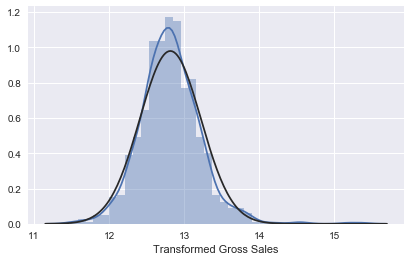

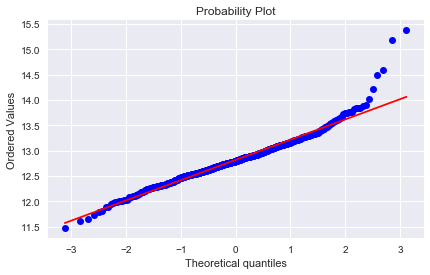

In [601]:
#transformed sales histogram and normal probability plot
sns.distplot(marketing_data['Transformed Gross Sales'], fit=norm);
fig = plt.figure()
res = stats.probplot(marketing_data['Transformed Gross Sales'], plot=plt)

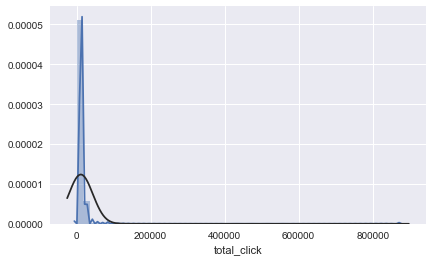

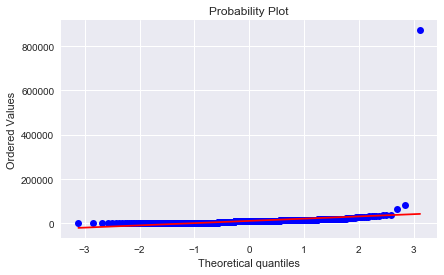

In [602]:
#total click histogram and normal probability plot
sns.distplot(marketing_data['total_click'], fit=norm);
fig = plt.figure()
res = stats.probplot(marketing_data['total_click'], plot=plt)

In [603]:
#applying log transformation on total click
marketing_data['transformed_click'] = np.log(marketing_data['total_click'])

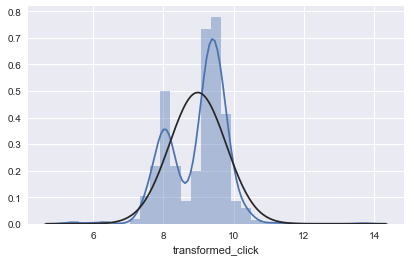

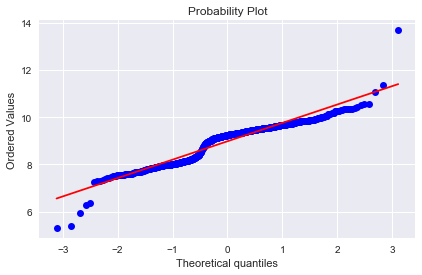

In [604]:
#transformed click histogram and normal probability plot
sns.distplot(marketing_data['transformed_click'], fit=norm);
fig = plt.figure()
res = stats.probplot(marketing_data['transformed_click'], plot=plt)

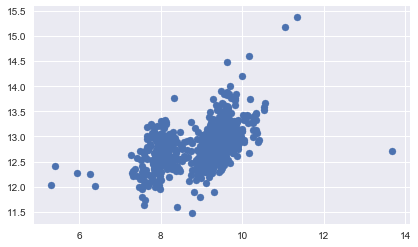

In [605]:
#scatter plot of transformed clicks and gross sales
plt.scatter(marketing_data['transformed_click'], marketing_data['Transformed Gross Sales']);

# 3. Model Fitting

## Total Gross Sales is at an Adj. R-Squared of 0.723

In [606]:
#dropped variables with all zeros: click_guideshop, click_catalog, spend_email, spend_guideshop
#total gross sales vs click, impression, and spend variables

X = marketing_data[['click_affiliate',
       'click_display_prospecting', 'click_display_retargeting',
       'click_email','click_paid_search',
       'click_paid_social','impressions_affiliate',
       'impressions_catalog', 'impressions_display_prospecting',
       'impressions_display_retargeting', 'impressions_email',
       'impressions_guideshop', 'impressions_paid_search',
       'impressions_paid_social','spend_affiliate',
       'spend_catalog', 'spend_display_prospecting',
       'spend_display_retargeting',
       'spend_paid_search', 'spend_paid_social','spend_linkedin', 'impressions_linkedin',
       'click_linkedin', 'impressions_quartz', 'click_quartz',
       'impressions_pandora', 'click_pandora', 'spend_thehustle',
       'impressions_thehustle', 'click_thehustle', 'spend_ooh',
       'impressions_ooh', 'spend_print', 'impressions_print',
       'organic_instagram_reach', 'organic_impressions_twitter',
       'organic_click_twitter']] ## X usually means our input variables (or independent variables)
y = marketing_data["Total Gross Sales"] ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Total Gross Sales   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     53.94
Date:                Mon, 29 Jan 2018   Prob (F-statistic):          3.94e-180
Time:                        17:52:37   Log-Likelihood:                -9979.6
No. Observations:                 752   AIC:                         2.004e+04
Df Residuals:                     714   BIC:                         2.021e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                           -6691.2398   2.45e+04     -0.273      0.785   -5.48e+04    4.14e+04
click_affiliate                    25.8093      4.892      5.276      0.000      16.205      35.414
click_display_prospecting          42.8386     66.055      0.649      0.517     -86.848     172.525
click_display_retargeting          -0.5449      5.982     -0.091      0.927     -12.290      11.200
click_email                        17.4941      2.314      7.560      0.000      12.951      22.037
click_paid_search                  57.5332      7.916      7.268      0.000      41.991      73.076
click_paid_social                 -31.7203     12.494     -2.539      0.011     -56.251      -7.190
impressions_affiliate              -0.1379      0.028     -4.888      0.000      -0.193      -0.082
impressions_catalog                 0.1969      0.122      1.608      0.108      -0.043       0.437
impressions_display_prospecting     0.1497      0.059      2.543      0.011       0.034       0.265
impressions_display_retargeting    -0.3269      0.036     -9.158      0.000      -0.397      -0.257
impressions_email                   0.1893      0.282      0.671      0.503      -0.365       0.743
impressions_guideshop              38.3743      5.430      7.068      0.000      27.714      49.034
impressions_paid_search            -0.0839      0.030     -2.787      0.005      -0.143      -0.025
impressions_paid_social            -0.1492      0.045     -3.349      0.001      -0.237      -0.062
spend_affiliate                     0.4091      0.728      0.562      0.574      -1.020       1.838
spend_catalog                      -0.3389      0.244     -1.388      0.166      -0.818       0.141
spend_display_prospecting          11.1103     14.820      0.750      0.454     -17.985      40.206
spend_display_retargeting          70.9066      7.072     10.026      0.000      57.022      84.791
spend_paid_search                   2.8830      3.711      0.777      0.438      -4.404      10.170
spend_paid_social                  36.1331      5.680      6.361      0.000      24.981      47.285
spend_linkedin                    379.3054    146.633      2.587      0.010      91.421     667.190
impressions_linkedin              -10.3781     12.514     -0.829      0.407     -34.947      14.191
click_linkedin                  -2891.6740   2178.461     -1.327      0.185   -7168.630    1385.282
impressions_quartz                  1.3748      2.049      0.671      0.503      -2.649       5.398
click_quartz                     -424.2265    380.518     -1.115      0.265   -1171.294     322.841
impressions_pandora                 0.3016      1.759      0.171      0.864      -3.152       3.756
click_pandora                     460.2745    401.002      1.148      0.251    -327

## Web Gross Sales is at an Adj. R-Squared of 0.700

In [608]:
#dropped variables with all zeros: click_guideshop, click_catalog, spend_email, spend_guideshop
#web gross sales vs click, impression, and spend variables

X = marketing_data[['click_affiliate',
       'click_display_prospecting', 'click_display_retargeting',
       'click_email','click_paid_search',
       'click_paid_social','impressions_affiliate',
       'impressions_catalog', 'impressions_display_prospecting',
       'impressions_display_retargeting', 'impressions_email',
       'impressions_guideshop', 'impressions_paid_search',
       'impressions_paid_social','spend_affiliate',
       'spend_catalog', 'spend_display_prospecting',
       'spend_display_retargeting',
       'spend_paid_search', 'spend_paid_social','spend_linkedin', 'impressions_linkedin',
       'click_linkedin', 'impressions_quartz', 'click_quartz',
       'impressions_pandora', 'click_pandora', 'spend_thehustle',
       'impressions_thehustle', 'click_thehustle', 'spend_ooh',
       'impressions_ooh', 'spend_print', 'impressions_print',
       'organic_instagram_reach', 'organic_impressions_twitter',
       'organic_click_twitter']] ## X usually means our input variables (or independent variables)
y = marketing_data['Web Gross Sales'] ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Web Gross Sales   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     48.38
Date:                Mon, 29 Jan 2018   Prob (F-statistic):          4.06e-168
Time:                        17:53:23   Log-Likelihood:                -9916.8
No. Observations:                 752   AIC:                         1.991e+04
Df Residuals:                     714   BIC:                         2.009e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            5904.0570   2.25e+04      0.262      0.793   -3.83e+04    5.01e+04
click_affiliate                    23.6041      4.500      5.245      0.000      14.769      32.439
click_display_prospecting          29.9290     60.762      0.493      0.622     -89.364     149.222
click_display_retargeting          -0.3794      5.503     -0.069      0.945     -11.183      10.424
click_email                        17.3085      2.129      8.131      0.000      13.129      21.488
click_paid_search                  56.4663      7.282      7.754      0.000      42.170      70.763
click_paid_social                 -35.6938     11.493     -3.106      0.002     -58.258     -13.129
impressions_affiliate              -0.1388      0.026     -5.351      0.000      -0.190      -0.088
impressions_catalog                 0.1873      0.113      1.663      0.097      -0.034       0.408
impressions_display_prospecting     0.1151      0.054      2.126      0.034       0.009       0.221
impressions_display_retargeting    -0.3047      0.033     -9.280      0.000      -0.369      -0.240
impressions_email                   0.1410      0.260      0.543      0.587      -0.369       0.651
impressions_guideshop              -4.7172      4.994     -0.944      0.345     -14.523       5.088
impressions_paid_search            -0.0912      0.028     -3.293      0.001      -0.146      -0.037
impressions_paid_social            -0.1303      0.041     -3.178      0.002      -0.211      -0.050
spend_affiliate                     0.5612      0.669      0.838      0.402      -0.753       1.876
spend_catalog                      -0.3220      0.225     -1.434      0.152      -0.763       0.119
spend_display_prospecting          15.0612     13.632      1.105      0.270     -11.702      41.825
spend_display_retargeting          66.0133      6.505     10.148      0.000      53.242      78.785
spend_paid_search                   1.2789      3.414      0.375      0.708      -5.424       7.982
spend_paid_social                  32.0666      5.225      6.137      0.000      21.809      42.325
spend_linkedin                    300.8126    134.882      2.230      0.026      36.000     565.625
impressions_linkedin               -8.3204     11.511     -0.723      0.470     -30.920      14.279
click_linkedin                  -2418.4273   2003.876     -1.207      0.228   -6352.621    1515.767
impressions_quartz                  1.2203      1.885      0.647      0.518      -2.481       4.921
click_quartz                     -387.3784    350.023     -1.107      0.269   -1074.575     299.818
impressions_pandora                 0.7898      1.618      0.488      0.626      -2.387       3.967
click_pandora                     328.7949    368.865      0.891      0.373    -395

## Guideshop Gross Sales is at an Adj. R-Squared of 0.876

In [609]:
#dropped variables with all zeros: click_guideshop, click_catalog, spend_email, spend_guideshop
#guideshop gross sales vs click, impression, and spend variables

X = marketing_data[['click_affiliate',
       'click_display_prospecting', 'click_display_retargeting',
       'click_email','click_paid_search',
       'click_paid_social','impressions_affiliate',
       'impressions_catalog', 'impressions_display_prospecting',
       'impressions_display_retargeting', 'impressions_email',
       'impressions_guideshop', 'impressions_paid_search',
       'impressions_paid_social','spend_affiliate',
       'spend_catalog', 'spend_display_prospecting',
       'spend_display_retargeting',
       'spend_paid_search', 'spend_paid_social','spend_linkedin', 'impressions_linkedin',
       'click_linkedin', 'impressions_quartz', 'click_quartz',
       'impressions_pandora', 'click_pandora', 'spend_thehustle',
       'impressions_thehustle', 'click_thehustle', 'spend_ooh',
       'impressions_ooh', 'spend_print', 'impressions_print',
       'organic_instagram_reach', 'organic_impressions_twitter',
       'organic_click_twitter']] ## X usually means our input variables (or independent variables)
y = marketing_data['Guideshop Sales'] ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Guideshop Sales   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     144.4
Date:                Mon, 29 Jan 2018   Prob (F-statistic):          1.74e-303
Time:                        17:53:24   Log-Likelihood:                -8589.5
No. Observations:                 752   AIC:                         1.726e+04
Df Residuals:                     714   BIC:                         1.743e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            -1.26e+04   3856.486     -3.266      0.001   -2.02e+04   -5023.889
click_affiliate                     2.2053      0.770      2.863      0.004       0.693       3.718
click_display_prospecting          12.9096     10.402      1.241      0.215      -7.512      33.331
click_display_retargeting          -0.1654      0.942     -0.176      0.861      -2.015       1.684
click_email                         0.1857      0.364      0.510      0.611      -0.530       0.901
click_paid_search                   1.0669      1.247      0.856      0.392      -1.381       3.514
click_paid_social                   3.9735      1.967      2.020      0.044       0.111       7.836
impressions_affiliate               0.0010      0.004      0.217      0.828      -0.008       0.010
impressions_catalog                 0.0096      0.019      0.499      0.618      -0.028       0.047
impressions_display_prospecting     0.0346      0.009      3.730      0.000       0.016       0.053
impressions_display_retargeting    -0.0222      0.006     -3.950      0.000      -0.033      -0.011
impressions_email                   0.0483      0.044      1.087      0.277      -0.039       0.136
impressions_guideshop              43.0915      0.855     50.400      0.000      41.413      44.770
impressions_paid_search             0.0073      0.005      1.537      0.125      -0.002       0.017
impressions_paid_social            -0.0190      0.007     -2.707      0.007      -0.033      -0.005
spend_affiliate                    -0.1520      0.115     -1.326      0.185      -0.377       0.073
spend_catalog                      -0.0168      0.038     -0.438      0.661      -0.092       0.059
spend_display_prospecting          -3.9509      2.334     -1.693      0.091      -8.532       0.631
spend_display_retargeting           4.8933      1.114      4.394      0.000       2.707       7.080
spend_paid_search                   1.6041      0.584      2.745      0.006       0.457       2.751
spend_paid_social                   4.0665      0.894      4.546      0.000       2.311       5.823
spend_linkedin                     78.4928     23.090      3.399      0.001      33.160     123.825
impressions_linkedin               -2.0577      1.971     -1.044      0.297      -5.926       1.811
click_linkedin                   -473.2467    343.038     -1.380      0.168   -1146.731     200.238
impressions_quartz                  0.1545      0.323      0.479      0.632      -0.479       0.788
click_quartz                      -36.8482     59.919     -0.615      0.539    -154.488      80.791
impressions_pandora                -0.4882      0.277     -1.762      0.078      -1.032       0.056
click_pandora                     131.4796     63.145      2.082      0.038       7

## Web Traffic is at an Adj. R-Squared of 0.761

In [611]:
#dropped variables with all zeros: click_guideshop, click_catalog, spend_email, spend_guideshop
#guideshop gross sales vs click, impression, and spend variables

X = marketing_data[['click_affiliate',
       'click_display_prospecting', 'click_display_retargeting',
       'click_email','click_paid_search',
       'click_paid_social','impressions_affiliate',
       'impressions_catalog', 'impressions_display_prospecting',
       'impressions_display_retargeting', 'impressions_email',
       'impressions_guideshop', 'impressions_paid_search',
       'impressions_paid_social','spend_affiliate',
       'spend_catalog', 'spend_display_prospecting',
       'spend_display_retargeting',
       'spend_paid_search', 'spend_paid_social','spend_linkedin', 'impressions_linkedin',
       'click_linkedin', 'impressions_quartz', 'click_quartz',
       'impressions_pandora', 'click_pandora', 'spend_thehustle',
       'impressions_thehustle', 'click_thehustle', 'spend_ooh',
       'impressions_ooh', 'spend_print', 'impressions_print',
       'organic_instagram_reach', 'organic_impressions_twitter',
       'organic_click_twitter']] ## X usually means our input variables (or independent variables)
y = marketing_data['Web Traffic'] ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Web Traffic   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     65.57
Date:                Mon, 29 Jan 2018   Prob (F-statistic):          1.25e-202
Time:                        17:53:25   Log-Likelihood:                -7535.0
No. Observations:                 752   AIC:                         1.515e+04
Df Residuals:                     714   BIC:                         1.532e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            1.978e+04    948.791     20.844      0.000    1.79e+04    2.16e+04
click_affiliate                     1.2940      0.190      6.828      0.000       0.922       1.666
click_display_prospecting          -1.9827      2.559     -0.775      0.439      -7.007       3.041
click_display_retargeting           0.6000      0.232      2.589      0.010       0.145       1.055
click_email                         1.5329      0.090     17.098      0.000       1.357       1.709
click_paid_search                   3.9964      0.307     13.031      0.000       3.394       4.599
click_paid_social                  -0.2464      0.484     -0.509      0.611      -1.197       0.704
impressions_affiliate              -0.0065      0.001     -5.918      0.000      -0.009      -0.004
impressions_catalog                 0.0057      0.005      1.200      0.231      -0.004       0.015
impressions_display_prospecting     0.0036      0.002      1.596      0.111      -0.001       0.008
impressions_display_retargeting    -0.0079      0.001     -5.747      0.000      -0.011      -0.005
impressions_email                  -0.0683      0.011     -6.246      0.000      -0.090      -0.047
impressions_guideshop              -1.1938      0.210     -5.675      0.000      -1.607      -0.781
impressions_paid_search            -0.0066      0.001     -5.626      0.000      -0.009      -0.004
impressions_paid_social            -0.0055      0.002     -3.169      0.002      -0.009      -0.002
spend_affiliate                     0.0352      0.028      1.248      0.212      -0.020       0.091
spend_catalog                      -0.0105      0.009     -1.115      0.265      -0.029       0.008
spend_display_prospecting           0.1964      0.574      0.342      0.732      -0.931       1.324
spend_display_retargeting           1.4238      0.274      5.197      0.000       0.886       1.962
spend_paid_search                  -0.2493      0.144     -1.734      0.083      -0.532       0.033
spend_paid_social                   1.0600      0.220      4.817      0.000       0.628       1.492
spend_linkedin                      2.5592      5.681      0.450      0.652      -8.594      13.712
impressions_linkedin                0.1262      0.485      0.260      0.795      -0.826       1.078
click_linkedin                    -35.8623     84.396     -0.425      0.671    -201.556     129.832
impressions_quartz                  0.0356      0.079      0.449      0.654      -0.120       0.191
click_quartz                       -8.8427     14.742     -0.600      0.549     -37.785      20.099
impressions_pandora                 0.0267      0.068      0.392      0.695      -0.107       0.161
click_pandora                      24.2415     15.535      1.560      0.119      -6

In [612]:
var = ['click_display_prospecting',
'click_display_retargeting',
'click_paid_social',
'impressions_catalog',
'impressions_email',
'spend_affiliate',
'spend_catalog',
'spend_display_prospecting',
'spend_paid_search',
'Total Gross Sales']

marketing_data_outliers_removed = marketing_data[(np.abs(stats.zscore(marketing_data[var])) < 3).all(axis=1)]

In [613]:
#dropped variables with all zeros: click_guideshop, click_catalog, spend_email, spend_guideshop
#total gross sales vs click, impression, and spend variables

X = marketing_data_outliers_removed[['click_affiliate',
       'click_display_prospecting', 'click_display_retargeting',
       'click_email','click_paid_search',
       'click_paid_social','impressions_affiliate',
       'impressions_catalog', 'impressions_display_prospecting',
       'impressions_display_retargeting', 'impressions_email',
       'impressions_guideshop', 'impressions_paid_search',
       'impressions_paid_social','spend_affiliate',
       'spend_catalog', 'spend_display_prospecting',
       'spend_display_retargeting',
       'spend_paid_search', 'spend_paid_social','spend_linkedin', 'impressions_linkedin',
       'click_linkedin', 'impressions_quartz', 'click_quartz',
       'impressions_pandora', 'click_pandora', 'spend_thehustle',
       'impressions_thehustle', 'click_thehustle', 'spend_ooh',
       'impressions_ooh', 'spend_print', 'impressions_print',
       'organic_instagram_reach', 'organic_impressions_twitter',
       'organic_click_twitter']] ## X usually means our input variables (or independent variables)
y = marketing_data_outliers_removed["Total Gross Sales"] ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Total Gross Sales   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     20.21
Date:                Mon, 29 Jan 2018   Prob (F-statistic):           6.77e-85
Time:                        17:53:25   Log-Likelihood:                -9016.2
No. Observations:                 696   AIC:                         1.811e+04
Df Residuals:                     658   BIC:                         1.828e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            1.186e+05    2.2e+04      5.386      0.000    7.53e+04    1.62e+05
click_affiliate                    15.9993      3.979      4.021      0.000       8.186      23.812
click_display_prospecting          26.2432     66.014      0.398      0.691    -103.379     155.866
click_display_retargeting           6.0098      4.719      1.273      0.203      -3.257      15.276
click_email                         8.0816      1.888      4.281      0.000       4.375      11.788
click_paid_search                  25.2171      6.499      3.880      0.000      12.455      37.979
click_paid_social                  14.9668     11.050      1.354      0.176      -6.730      36.664
impressions_affiliate              -0.0967      0.022     -4.342      0.000      -0.140      -0.053
impressions_catalog              1962.4134   1411.781      1.390      0.165    -809.726    4734.552
impressions_display_prospecting     0.0804      0.051      1.584      0.114      -0.019       0.180
impressions_display_retargeting    -0.1655      0.034     -4.927      0.000      -0.231      -0.100
impressions_email                  -0.0840      0.221     -0.380      0.704      -0.517       0.349
impressions_guideshop              32.4287      4.426      7.327      0.000      23.738      41.120
impressions_paid_search            -0.0446      0.023     -1.912      0.056      -0.090       0.001
impressions_paid_social            -0.0974      0.034     -2.853      0.004      -0.164      -0.030
spend_affiliate                     6.0367      2.073      2.913      0.004       1.967      10.107
spend_catalog                   -6060.0639   4360.297     -1.390      0.165   -1.46e+04    2501.710
spend_display_prospecting          -4.1073     13.026     -0.315      0.753     -29.685      21.470
spend_display_retargeting          48.0055      6.151      7.804      0.000      35.927      60.084
spend_paid_search                   1.0123      3.107      0.326      0.745      -5.089       7.113
spend_paid_social                  16.8531      4.637      3.635      0.000       7.749      25.958
spend_linkedin                    174.9416    118.681      1.474      0.141     -58.098     407.981
impressions_linkedin                2.6051      9.708      0.268      0.789     -16.457      21.667
click_linkedin                  -2449.3701   1729.861     -1.416      0.157   -5846.084     947.343
impressions_quartz                  1.1201      1.564      0.716      0.474      -1.952       4.192
click_quartz                     -386.3864    310.376     -1.245      0.214    -995.833     223.060
impressions_pandora                -0.4416      1.402     -0.315      0.753      -3.194       2.311
click_pandora                     165.0124    308.160      0.535      0.593    -440

In [614]:
marketing_data[['click_affiliate_transformed',
       'click_display_prospecting_transformed', 'click_display_retargeting_transformed',
       'click_email_transformed','click_paid_search_transformed',
       'click_paid_social_transformed','impressions_affiliate_transformed',
       'impressions_catalog_transformed', 'impressions_display_prospecting_transformed',
       'impressions_display_retargeting_transformed', 'impressions_email_transformed',
       'impressions_guideshop_transformed', 'impressions_paid_search_transformed',
       'impressions_paid_social_transformed','spend_affiliate_transformed',
       'spend_catalog_transformed', 'spend_display_prospecting_transformed',
       'spend_display_retargeting_transformed',
       'spend_paid_search_transformed', 'spend_paid_social','Transformed Total Gross Sales']] = np.log(marketing_data[['click_affiliate',
       'click_display_prospecting', 'click_display_retargeting',
       'click_email','click_paid_search',
       'click_paid_social','impressions_affiliate',
       'impressions_catalog', 'impressions_display_prospecting',
       'impressions_display_retargeting', 'impressions_email',
       'impressions_guideshop', 'impressions_paid_search',
       'impressions_paid_social','spend_affiliate',
       'spend_catalog', 'spend_display_prospecting',
       'spend_display_retargeting',
       'spend_paid_search', 'spend_paid_social','Total Gross Sales']])

/Users/derekku/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


In [615]:
marketing_data[['click_affiliate_transformed',
       'click_display_prospecting_transformed', 'click_display_retargeting_transformed',
       'click_email_transformed','click_paid_search_transformed',
       'click_paid_social_transformed','impressions_affiliate_transformed',
       'impressions_catalog_transformed', 'impressions_display_prospecting_transformed',
       'impressions_display_retargeting_transformed', 'impressions_email_transformed',
       'impressions_guideshop_transformed', 'impressions_paid_search_transformed',
       'impressions_paid_social_transformed','spend_affiliate_transformed',
       'spend_catalog_transformed', 'spend_display_prospecting_transformed',
       'spend_display_retargeting_transformed',
       'spend_paid_search_transformed', 'spend_paid_social','Transformed Total Gross Sales']] = marketing_data[['click_affiliate_transformed',
       'click_display_prospecting_transformed', 'click_display_retargeting_transformed',
       'click_email_transformed','click_paid_search_transformed',
       'click_paid_social_transformed','impressions_affiliate_transformed',
       'impressions_catalog_transformed', 'impressions_display_prospecting_transformed',
       'impressions_display_retargeting_transformed', 'impressions_email_transformed',
       'impressions_guideshop_transformed', 'impressions_paid_search_transformed',
       'impressions_paid_social_transformed','spend_affiliate_transformed',
       'spend_catalog_transformed', 'spend_display_prospecting_transformed',
       'spend_display_retargeting_transformed',
       'spend_paid_search_transformed', 'spend_paid_social','Transformed Total Gross Sales']].replace(-np.inf,0)

In [616]:
#dropped variables with all zeros: click_guideshop, click_catalog, spend_email, spend_guideshop
#total gross sales vs click, impression, and spend variables
X = marketing_data[['click_affiliate_transformed',
       'click_display_prospecting_transformed', 'click_display_retargeting_transformed',
       'click_email_transformed','click_paid_search_transformed',
       'click_paid_social_transformed','impressions_affiliate_transformed',
       'impressions_catalog_transformed', 'impressions_display_prospecting_transformed',
       'impressions_display_retargeting_transformed', 'impressions_email_transformed',
       'impressions_guideshop_transformed', 'impressions_paid_search_transformed',
       'impressions_paid_social_transformed','spend_affiliate_transformed',
       'spend_catalog_transformed', 'spend_display_prospecting_transformed',
       'spend_display_retargeting_transformed',
       'spend_paid_search_transformed', 'spend_paid_social']]  ## X usually means our input variables (or independent variables)
y = marketing_data["Transformed Total Gross Sales"] ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Transformed Total Gross Sales   R-squared:                       0.545
Model:                                       OLS   Adj. R-squared:                  0.533
Method:                            Least Squares   F-statistic:                     43.84
Date:                           Mon, 29 Jan 2018   Prob (F-statistic):          1.20e-110
Time:                                   17:53:26   Log-Likelihood:                -95.048
No. Observations:                            752   AIC:                             232.1
Df Residuals:                                731   BIC:                             329.2
Df Model:                                     20                                         
Covariance Type:                       nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          12.2099      0.234     52.086      0.000      11.750      12.670
click_affiliate_transformed                     0.0463      0.029      1.571      0.117      -0.012       0.104
click_display_prospecting_transformed           0.1655      0.033      5.071      0.000       0.101       0.230
click_display_retargeting_transformed          -0.0543      0.030     -1.789      0.074      -0.114       0.005
click_email_transformed                         0.1906      0.030      6.459      0.000       0.133       0.248
click_paid_search_transformed                   0.1249      0.034      3.633      0.000       0.057       0.192
click_paid_social_transformed                   0.0695      0.025      2.808      0.005       0.021       0.118
impressions_affiliate_transformed              -0.0832      0.014     -6.115      0.000      -0.110      -0.056
impressions_catalog_transformed                 0.5148      0.241      2.137      0.033       0.042       0.988
impressions_display_prospecting_transformed    -0.0070      0.036     -0.196      0.845      -0.077       0.063
impressions_display_retargeting_transformed    -0.3158      0.046     -6.913      0.000      -0.406      -0.226
impressions_email_transformed                  -0.1576      0.023     -6.865      0.000      -0.203      -0.113
impressions_guideshop_transformed               0.1075      0.015      7.380      0.000       0.079       0.136
impressions_paid_search_transformed            -0.0959      0.012     -7.872      0.000      -0.120      -0.072
impressions_paid_social_transformed            -0.0784      0.017     -4.621      0.000      -0.112      -0.045
spend_affiliate_transformed                     0.0781      0.023      3.339      0.001       0.032       0.124
spend_catalog_transformed                      -0.5398      0.255     -2.113      0.035      -1.041      -0.038
spend_display_prospecting_transformed          -0.0294      0.041     -0.710      0.478      -0.111       0.052
spend_display_retargeting_transformed           0.3936      0.046      8.514      0.000       0.303       0.484
spend_paid_search_transformed                   0.1276      0.029      4.368      0.000       0.070       0.185
spend_paid_social                               0.0707      0.021      3.423      0.001       0.030       0.111
==============================================================================
Omnibus:                      117.076   Durbin-Watson:                   1.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              325.406
Skew:                           0.785